## [LangGraph Integration](https://langfuse.com/guides/cookbook/integration_langgraph)

**What is LangGraph?**

LangGraph is an open-source framework by the LangChain team for building **complex, stateful, multi-agent applications using large language models (LLMs)**. LangGraph includes built-in persistence to save and resume state, which enables error recovery and human-in-the-loop workflows.

Demonstrates how Langfuse helps to debug, analyze, and iterate on your LangGraph application using the LangChain integration.

- Automatically trace LangGraph application via the Langfuse integration

- Monitor advanced multi-agent setups

- Add scores (like user feedback)

- Manage your prompts used in LangGraph with Langfuse


### Step 0 Initialize Langfuse


In [4]:
import os

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a"
os.environ["LANGFUSE_HOST"] = "http://localhost:3000"

# Your openai key
# os.environ["OPENAI_API_KEY"] = "f0c1fb9f5c534e55a66d9e539916fdb0.GQKa6HaX6MpT9ioJ"
os.environ["OPENAI_API_KEY"] = "73c80b33ad68446ea3f059efe5c1a65f.T2PZjYiHcT2JYx2a"
os.environ["OPENAI_BASE_URL"] = "https://open.bigmodel.cn/api/paas/v4"

In [5]:
from langfuse import get_client

langfuse = get_client()

# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

ModuleNotFoundError: No module named 'google.protobuf'

### Step 1: Simple chat app with LangGraph


#### 1. Create Agent


Create Agent. A StateGraph object defines our chatbot’s structure as a state machine. We will add nodes to represent the LLM and functions the chatbot can call, and edges to specify how the bot transitions between these functions.


In [ ]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="GLM-4.5", temperature=0.2)


# The chatbot node function takes the current State as input and returns an updated messages list.
# This is the basic pattern for all LangGraph node functions.
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

graph_builder.set_entry_point("chatbot")

graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

#### 2. Add Langfuse as callback to the invocation

Add then [Langfuse callback handler for LangChain](https://langfuse.com/integrations/frameworks/langchain) to trace the steps of our application: config={"callbacks": [langfuse_handler]}


In [12]:
from langfuse.langchain import CallbackHandler

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

for s in graph.stream(
    {"messages": [HumanMessage(content="Langfuse 功能是什么？")]},
    config={"callbacks": [langfuse_handler]},
):
    print(s)

{'chatbot': {'messages': [AIMessage(content='Langfuse 是一个**开源的 LLM 工程平台**，专门设计用于帮助开发者、研究人员和团队**构建、测试、监控和迭代**基于大型语言模型的应用程序。它的核心目标是让 LLM 应用开发过程更透明、更高效、更可靠。\n\n以下是 Langfuse 的主要功能，按核心模块划分：\n\n## 🧩 1. 追踪与可观测性\n*   **请求追踪：** 自动或手动记录每一次 LLM 调用的完整生命周期。这包括：\n    *   **输入/输出：** 用户提示、模型响应、中间步骤（如链式调用、工具使用）。\n    *   **元数据：** 时间戳、延迟、用户 ID、会话 ID、自定义标签等。\n    *   **Token 使用与成本：** 精确统计每次调用消耗的输入/输出 Token 数量，并根据模型定价自动计算成本（支持多种模型提供商）。\n    *   **模型参数：** 使用的模型名称、温度、Top-P 等配置。\n    *   **错误与异常：** 捕获并记录调用过程中发生的错误。\n*   **可视化追踪：** 在直观的 UI 中以时间线形式展示复杂的 LLM 调用链（例如 LangChain 链、Agent 执行过程），清晰地展示每个步骤的输入、输出、耗时和依赖关系。\n*   **会话管理：** 将来自同一用户或同一交互上下文的多次调用关联起来，形成完整的对话会话视图，便于理解整体交互流程和上下文传递。\n\n## 📊 2. 数据集管理与评估\n*   **创建与管理数据集：** 轻松构建用于测试和评估 LLM 应用的数据集。数据集包含输入提示、期望输出（可选）以及相关元数据。\n*   **运行评估：** 使用数据集对不同的模型版本、提示词版本或应用配置进行自动化或半自动化测试。\n*   **评估指标：** 内置或集成多种评估指标来衡量模型表现，例如：\n    *   **基于规则的指标：** 如答案是否包含特定关键词、长度是否符合要求。\n    *   **基于模型的指标：** 使用另一个 LLM（如 GPT-4）作为评判，评估相关性、事实性、流畅性、遵循指令程度等（如 ROUGE, BLEU, 自定义评分）。\n    *   **人工评估：** 支

[trace ](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?peek=ddc994f66aec19696203c7f40655c158&timestamp=2025-08-29T02%3A20%3A50.255Z)

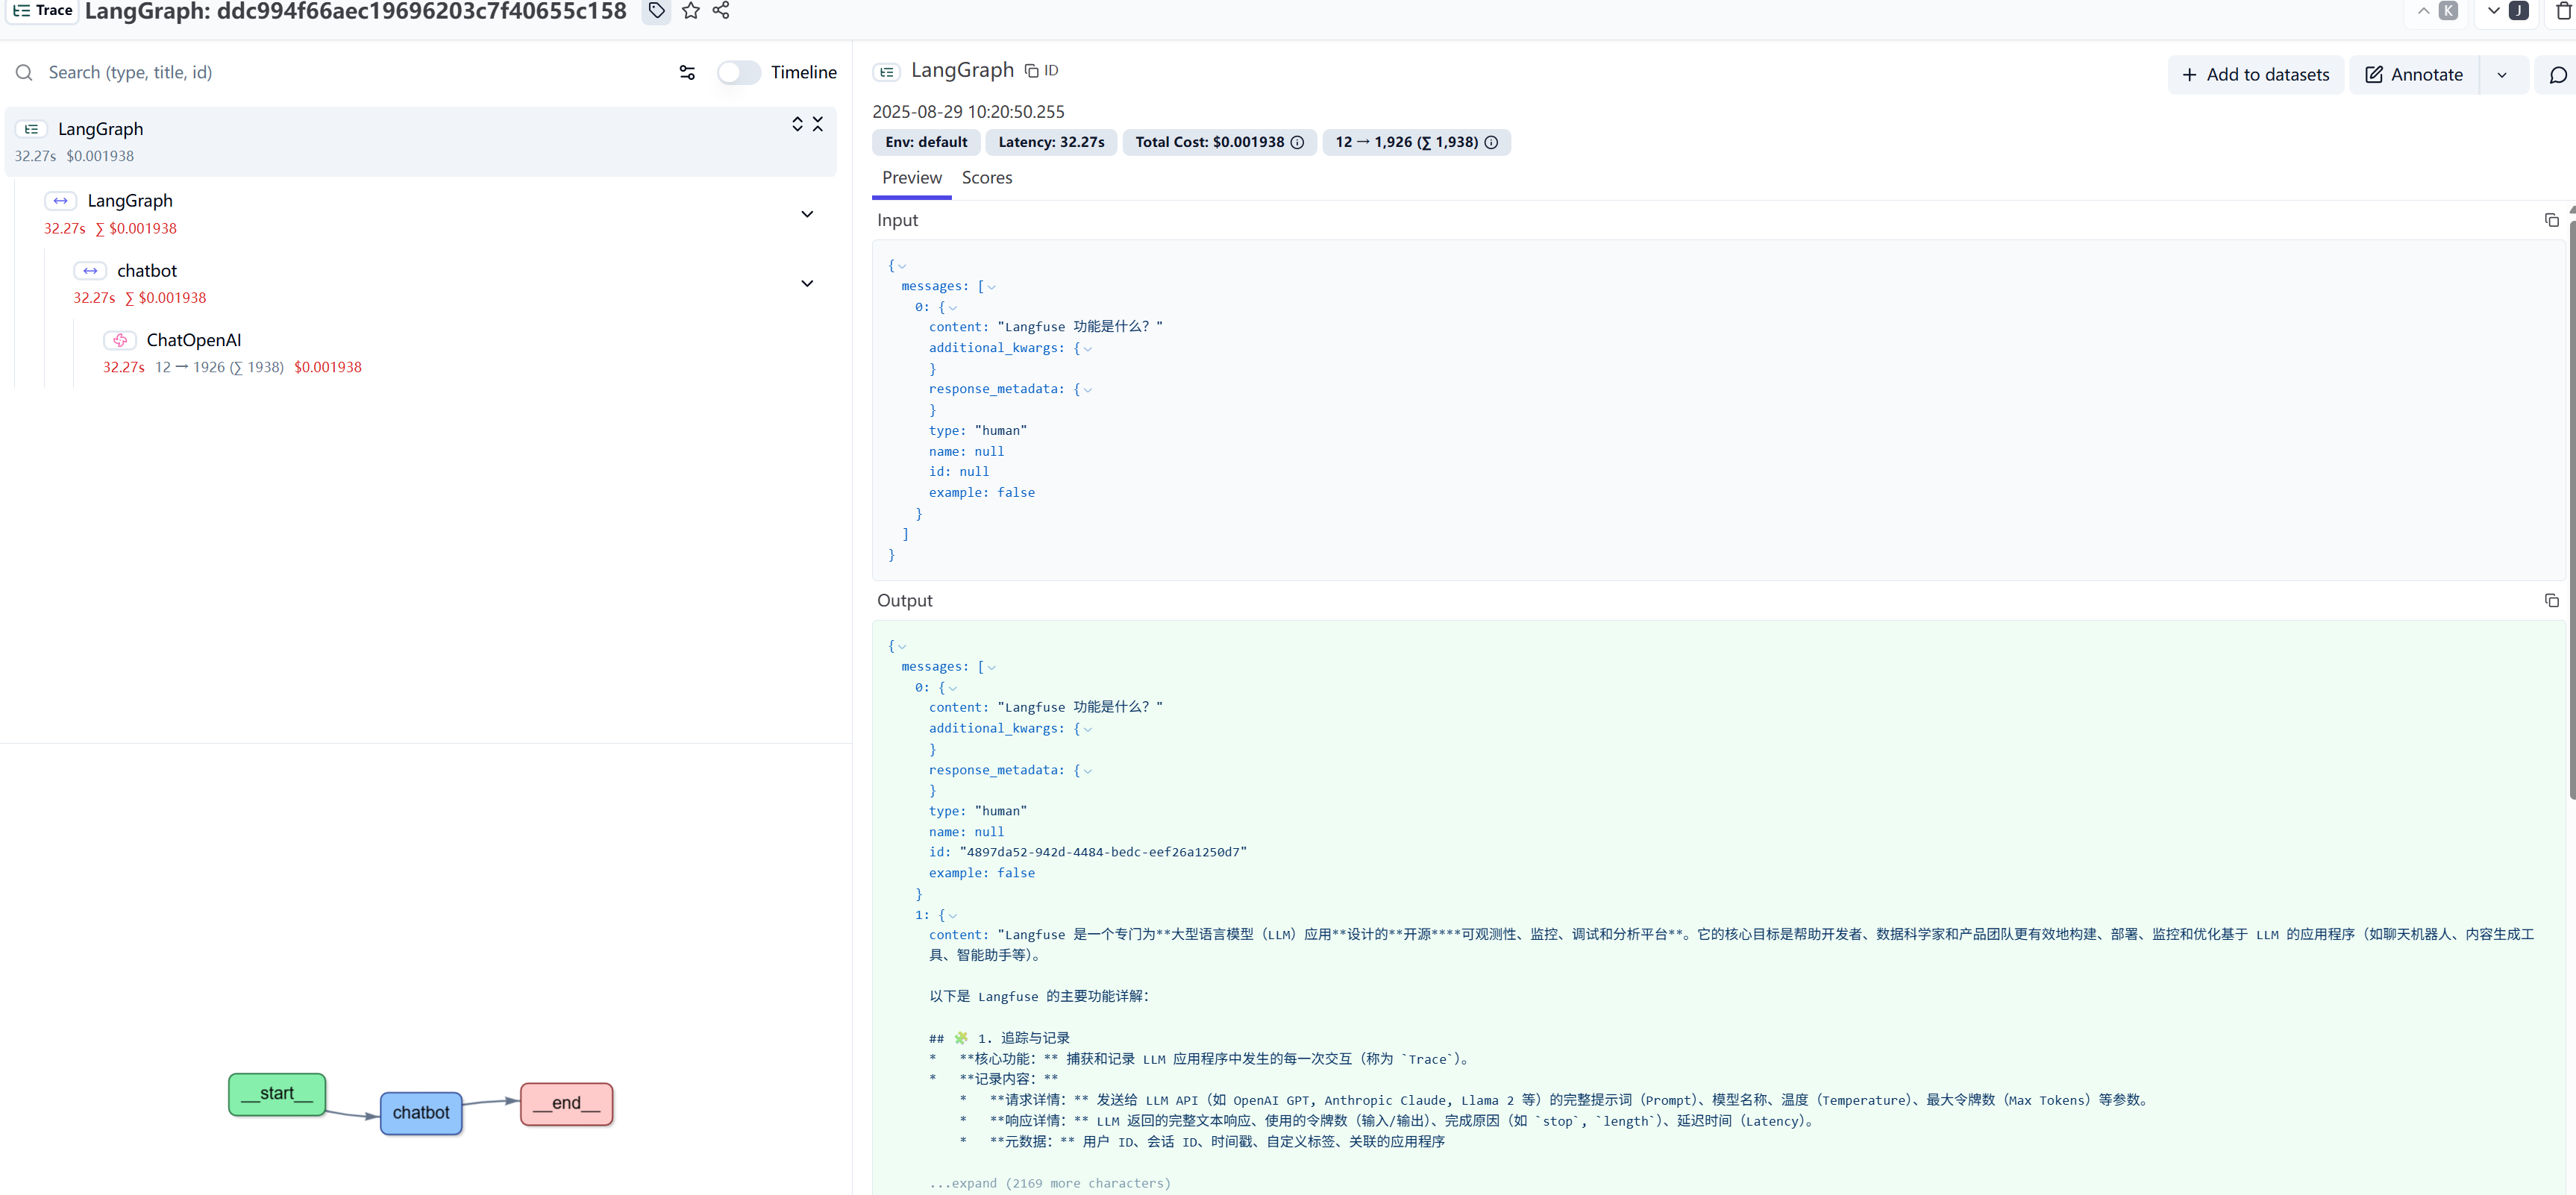


Visualize the chat app

You can visualize the graph using the get_graph method along with a “draw” method


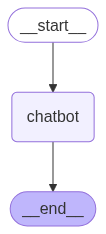

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### 3. Use Langfuse with LangGraph Server


When using the LangGraph Server, the LangGraph Server handles graph invocation automatically. Therefore, you should add the Langfuse callback when declaring the graph.


In [3]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

from langfuse.langchain import CallbackHandler


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="GLM-4.5-flash", temperature=0.2)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

# Call "with_config" from the compiled graph.
# It returns a "CompiledGraph", similar to "compile", but with callbacks included.
# This enables automatic graph tracing without needing to add callbacks manually every time.
graph = graph_builder.compile().with_config({"callbacks": [langfuse_handler]})

### Step 2: Multi agent application with LangGraph

- Build 2 executing agents: One research agent using the LangChain WikipediaAPIWrapper to search Wikipedia and one that uses a custom tool to get the current time.

- Build an agent supervisor to help delegate the user questions to one of the two agents

- Add Langfuse handler as callback to trace the steps of the supervisor and executing agents


In [15]:
%pip install langfuse langgraph langchain langchain_openai langchain_experimental pandas wikipedia

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11785 sha256=e0108ed49c4f01504dd24f17707685380a505a5588c4e5d6d549da5027247b86
  Stored in directory: c:\users\slsxz\appdata\local\pip\cache\wheels\f0\62\f0\e670bbca45ddbe196c9a5ab6f21d0aa1d5c54255a11b474e97
Successfully built wikipedia

   -------------------- ------------------- 1/2 [langchain_experimental]
   -------------------- ------------------- 1/2 [langchain_experimental]
   -------------------- ------------------- 1/2 [langchain_experimental]
   -------------------- ------------------- 1/2 [langchain_experimental]
   -------------------- ------------------- 1/2 [langchain_experimental]
   -------------------- ------------------- 1/2 [langchain_experimental]
   -------------------- ------------------- 1/2 [langchain_experimental]
   --------

  DEPRECATION: Building 'wikipedia' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'wikipedia'. Discussion can be found at https://github.com/pypa/pip/issues/6334


##### 1. Create tools


In [ ]:
from typing import Annotated

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from datetime import datetime
from langchain.tools import Tool

# Define a tools that searches Wikipedia
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

# Define a new tool that returns the current datetime
datetime_tool = Tool(
    name="Datetime",
    func=lambda x: datetime.now().isoformat(),
    description="Returns the current datetime",
)

#### 2. Helper utilities


In [ ]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, system_prompt: str, tools: list):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

#### 3. Create agent supervisor


In [ ]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Researcher", "CurrentTime"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Our team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed
options = ["FINISH"] + members

# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

# Create the prompt using ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="GLM-4.5")


# Construction of the chain for the supervisor agent
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

#### 3. Construct graph

Define the state and worker nodes using the function we just defined. Then we connect all the edges in the graph.


In [ ]:
import functools
import operator
from typing import Sequence, TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


# Add the research agent using the create_agent helper function
research_agent = create_agent(llm, "You are a web researcher.", [wikipedia_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Add the time agent using the create_agent helper function
currenttime_agent = create_agent(
    llm, "You can tell the current time at", [datetime_tool]
)
currenttime_node = functools.partial(
    agent_node, agent=currenttime_agent, name="CurrentTime"
)


workflow = StateGraph(AgentState)


# Add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.
workflow.add_node("Researcher", research_node)
workflow.add_node("CurrentTime", currenttime_node)
workflow.add_node("supervisor", supervisor_chain)

# We want our workers to ALWAYS "report back" to the supervisor when done
for member in members:
    workflow.add_edge(member, "supervisor")


# Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state.
# These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)


# Add an entry point. This tells our graph where to start its work each time we run it.
workflow.add_edge(START, "supervisor")


# To be able to run our graph, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.
graph_2 = workflow.compile()

#### 4. Add Langfuse as callback to the invocation

Add Langfuse handler as callback: config={"callbacks": [langfuse_handler]}


In [30]:
from langfuse.langchain import CallbackHandler

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()


for s in graph_2.stream(
    {"messages": [HumanMessage(content="How does photosynthesis work?")]},
    config={"callbacks": [langfuse_handler]},
):
    print(s)
    print("----")

OutputParserException: Could not parse function call: 'function_call'
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 

In [31]:
# Add Langfuse handler as callback: config={"callbacks": [langfuse_handler]}
for s in graph_2.stream(
    {"messages": [HumanMessage(content="What time is it?")]},
    config={"callbacks": [langfuse_handler]},
):
    print(s)
    print("----")

OutputParserException: Could not parse function call: 'function_call'
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 

#### 5. Example traces in Langfuse:

[How does photosynthesis work?](https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/7d5f970573b8214d1ca891251e42282c?observation=1437fadd113e6338)

[Visualize the agent](https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/3a69fe4998df50d42054f8944bd6a8d9)


#### 6. Visualize the agent


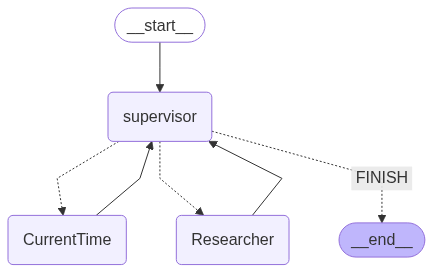

In [ ]:
from IPython.display import Image, display

display(Image(graph_2.get_graph().draw_mermaid_png()))

### Step 3: Multiple LangGraph Agents

There are setups where one LangGraph agent uses one or multiple other LangGraph agents. To combine all corresponding spans in one single trace for the multi agent execution, we can pass a custom trace_id.

First, we generate a trace_id that can be used for both agents to group the agent executions together in one Langfuse trace.


In [4]:
from langfuse import get_client, Langfuse
from langfuse.langchain import CallbackHandler

langfuse = get_client()

# Generate deterministic trace ID from external system
predefined_trace_id = Langfuse.create_trace_id()

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

#### 1. Create Sub-Agent


In [5]:
# sub-agent

from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="GLM-4.5-flash", temperature=0.2)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
sub_agent = graph_builder.compile()

#### 2. Create Tool


In [6]:
# Set the tool that uses the research-sub-agent to answer questions.

from langchain_core.tools import tool


@tool
def langgraph_research(question):
    """Conducts research for various topics."""

    with langfuse.start_as_current_span(
        name="🤖-sub-research-agent", trace_context={"trace_id": predefined_trace_id}
    ) as span:
        span.update_trace(input=question)

        response = sub_agent.invoke(
            {"messages": [HumanMessage(content=question)]},
            config={
                "callbacks": [langfuse_handler],
            },
        )

        span.update_trace(output=response["messages"][1].content)
    return response["messages"][1].content

In [9]:
# Set up a second simple LangGraph agent that uses the new langgraph_research.
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="GLM-4.5-Flash", temperature=0.2)

main_agent = create_react_agent(
    model=llm, tools=[langgraph_research], name="Multiple LangGraph Agents"
)

In [10]:
user_question = "What are LLM Observations Traces and Scores?"

# Use the predefined trace ID with trace_context
with langfuse.start_as_current_span(
    name="🤖-main-agent", trace_context={"trace_id": predefined_trace_id}
) as span:
    span.update_trace(input=user_question)

    # LangChain execution will be part of this trace
    response = main_agent.invoke(
        {"messages": [{"role": "user", "content": user_question}]},
        config={"callbacks": [langfuse_handler]},
    )

    span.update_trace(output=response["messages"][1].content)

print(f"Trace ID: {predefined_trace_id}")  # Use this for scoring later

Trace ID: 956a8194e4c7b07277a1b13263d07118


In [ ]:
# Summarize cost by model
import pandas as pd

trace = langfuse.api.trace.get("956a8194e4c7b07277a1b13263d07118")
observations = trace.observations


def summarize_usage(observations):
    """Summarize usage data grouped by model."""
    usage_data = []

    for obs in observations:
        usage = obs.usage
        if usage:
            usage_data.append(
                {
                    "model": obs.model,
                    "input_tokens": usage.input,
                    "output_tokens": usage.output,
                    "total_tokens": usage.total,
                }
            )

    df = pd.DataFrame(usage_data)
    if df.empty:
        return pd.DataFrame()

    summary = df.groupby("model").sum()
    return summary


# Example usage (assuming `observations` is defined as in the provided code):
summary_df = summarize_usage(observations)
summary_df

,input_tokens,output_tokens,total_tokens
model,,,
GLM-4.5-AirX,0,0,0
GLM-4.5-Flash,1883,2991,4874


: 

#### 3. Visualize the agent


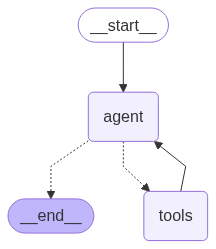

In [20]:
from IPython.display import Image, display

display(Image(main_agent.get_graph().draw_mermaid_png()))

#### [5. View traces in Langfuse](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/807c4036f9f4b59e18e63936996bbc88?timestamp=2025-08-29T09%3A13%3A22.340Z&display=preview&observation=f01d2b80a0e065ac&view=preview)

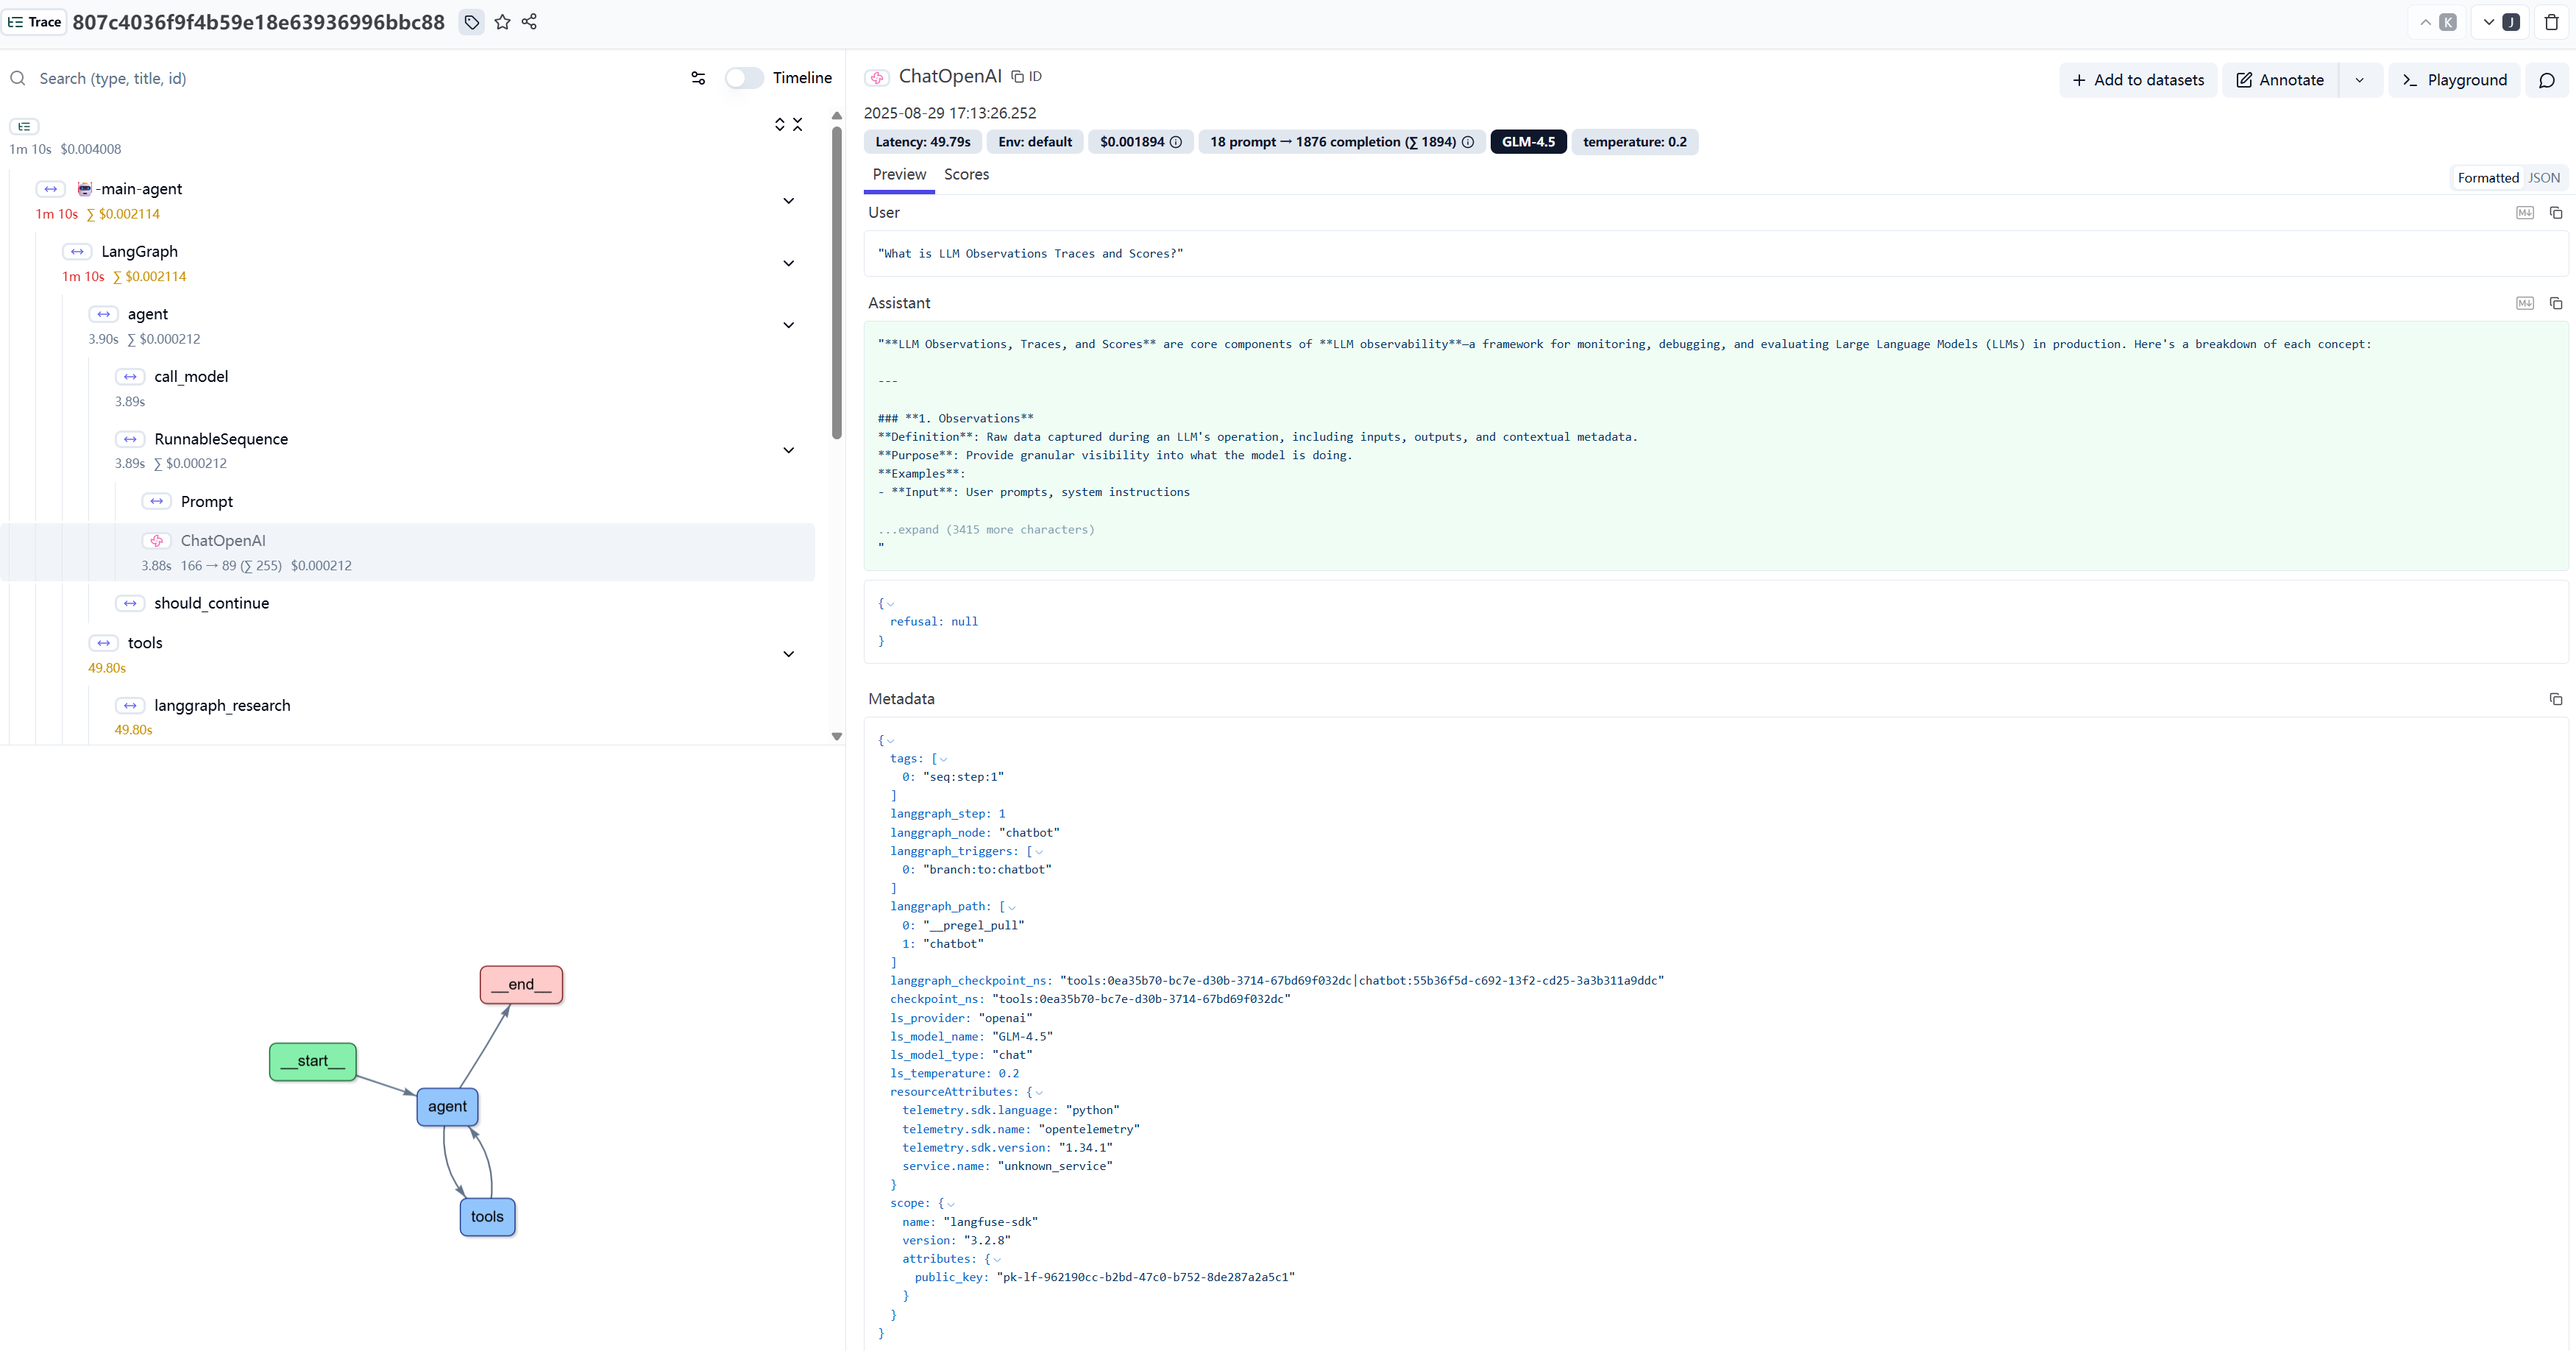


### Step 4: Adding scores to traces as scores

In [6]:
from langfuse import get_client
 
langfuse = get_client()
 
# Option 1: Use the yielded span object from the context manager
# with langfuse.start_as_current_span(
#     name="langgraph-request") as span:
#     # ... LangGraph execution ...
 
#     # Score using the span object
#     span.score_trace(
#         name="user-feedback",
#         value=1,
#         data_type="NUMERIC",
#         comment="This was correct, thank you"
#     )
 
# # Option 2: Use langfuse.score_current_trace() if still in context
# with langfuse.start_as_current_span(name="langgraph-request") as span:
#     # ... LangGraph execution ...
 
#     # Score using current context
#     langfuse.score_current_trace(
#         name="user-feedback",
#         value=1,
#         data_type="NUMERIC"
#     )
 
# Option 3: Use create_score() with trace ID (when outside context)
predefined_trace_id = "807c4036f9f4b59e18e63936996bbc88"
langfuse.create_score(
    trace_id=predefined_trace_id,
    name="user-feedback",
    value=1,
    data_type="NUMERIC",
    comment="This was correct, thank you"
)

[scores_trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/807c4036f9f4b59e18e63936996bbc88?view=scores)

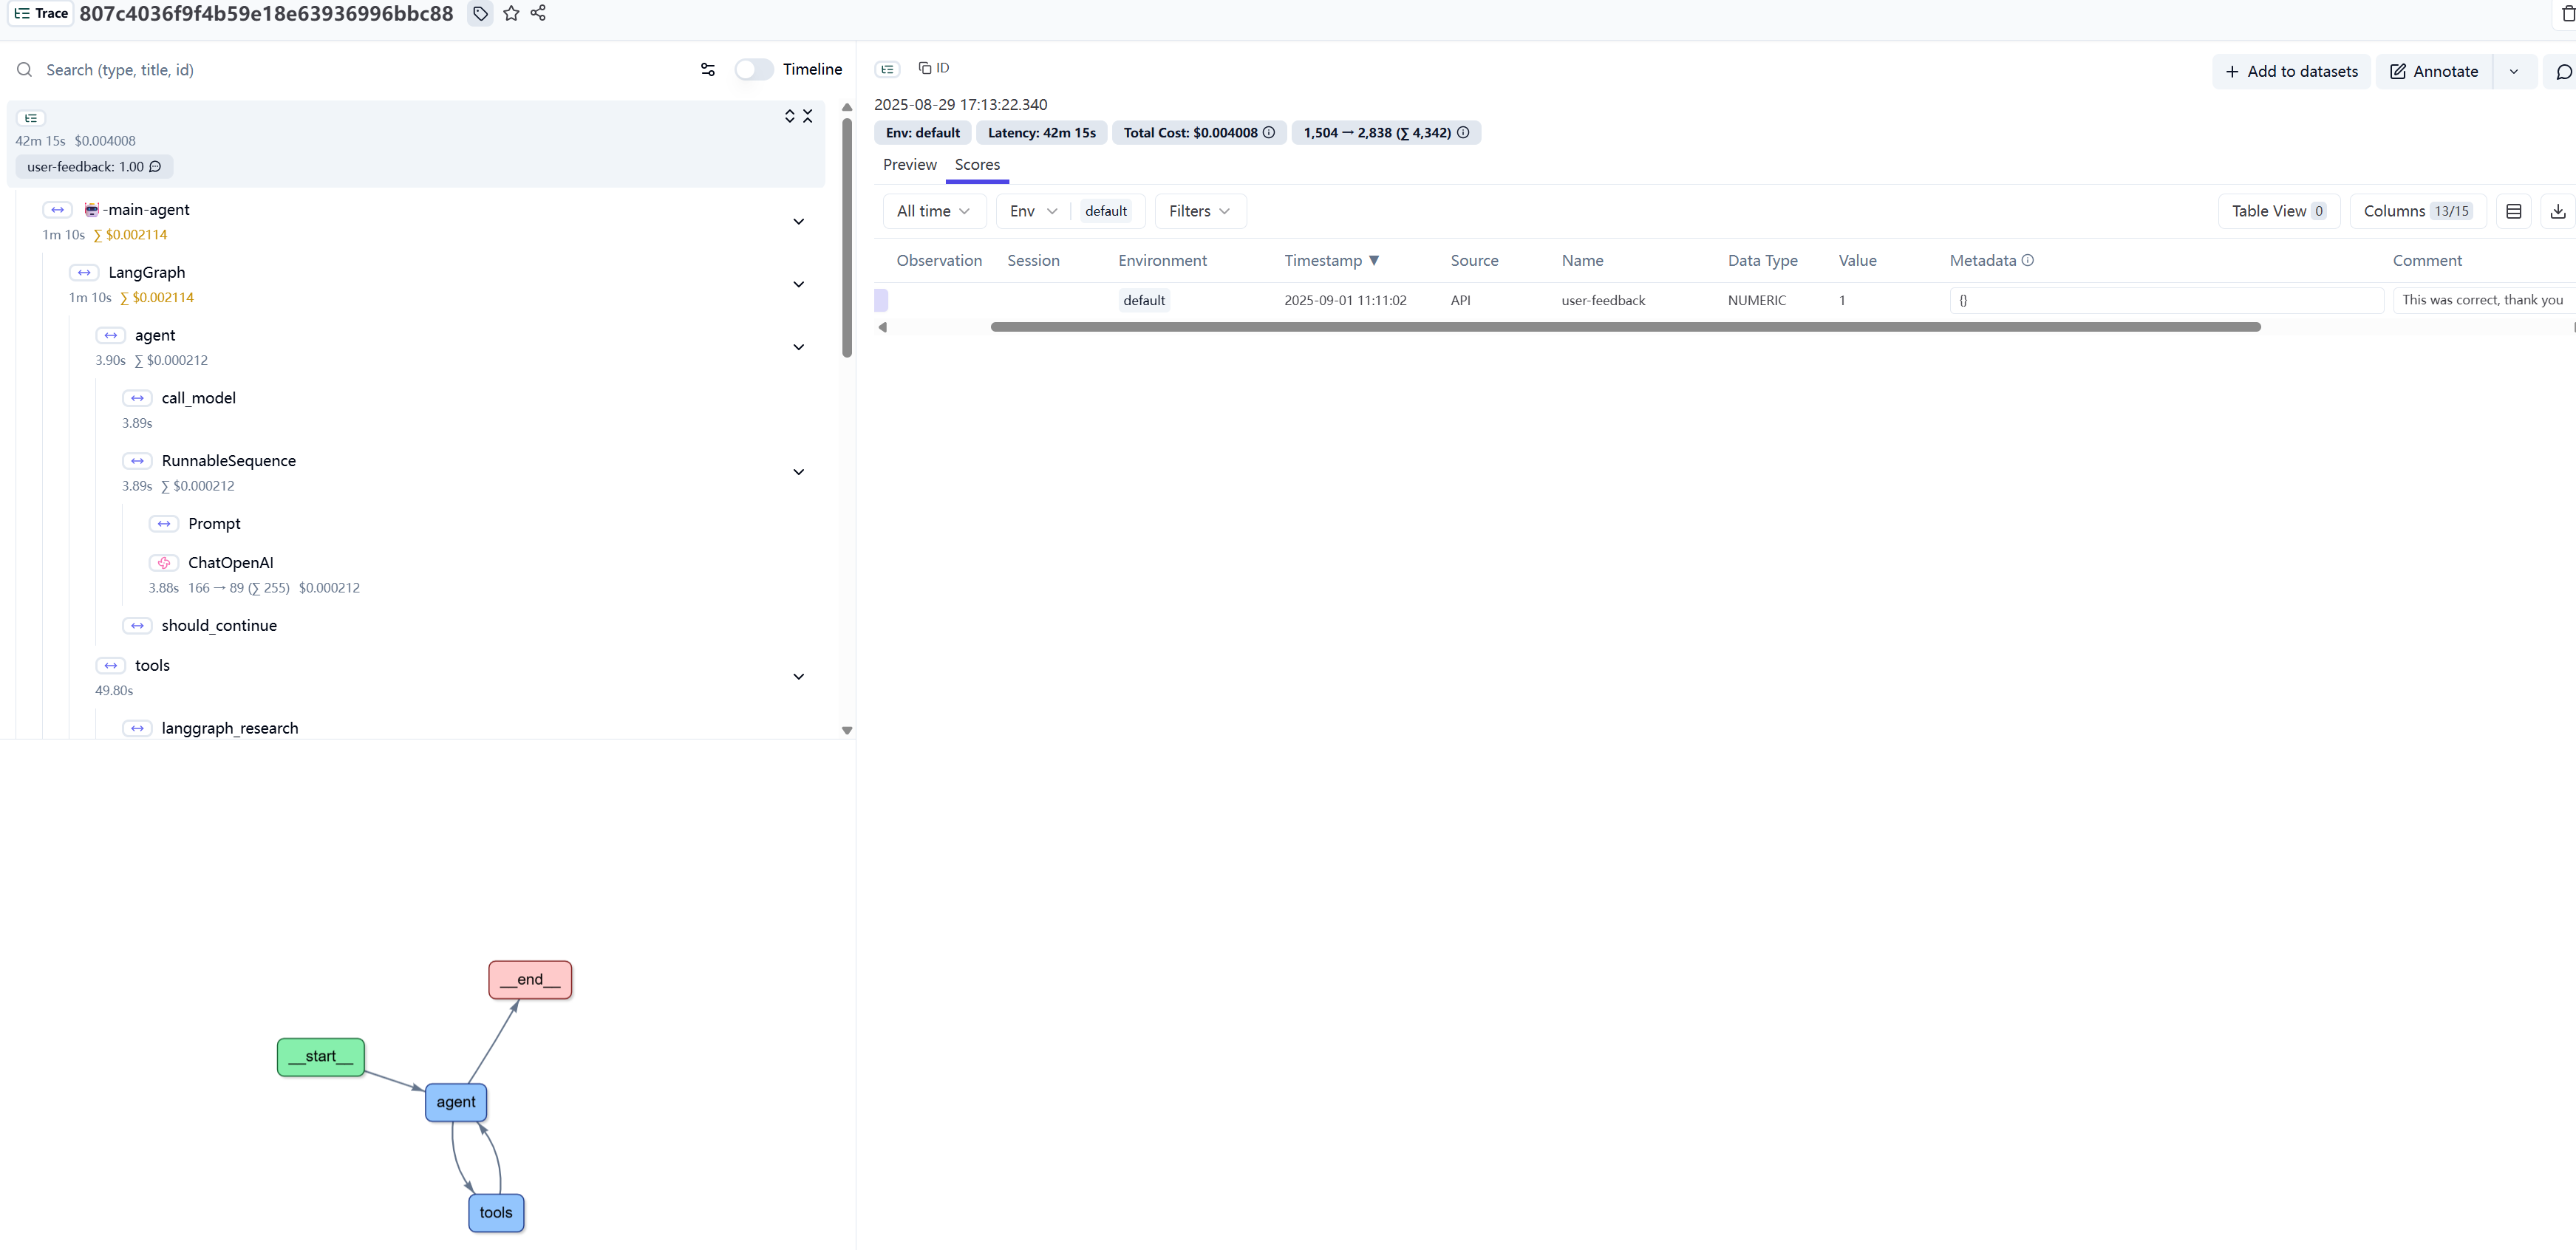

### Step 5: Manage prompts with Langfuse

Use [Langfuse prompt management](https://langfuse.com/guides/cookbook/prompt_management_langchain) to effectively manage and version your prompts. We add the prompt used in this example via the SDK. In production, however, users would update and manage the prompts via the Langfuse UI instead of using the SDK.

Langfuse prompt management is basically a Prompt CMS (Content Management System). Alternatively, you can also edit and version the prompt in the Langfuse UI.

* **Name** that identifies the prompt in Langfuse Prompt Management
* Prompt with prompt template incl. **{{input variables}}**
* **labels** to include **production** to immediately use prompt as the default


In [7]:
from langfuse import get_client
 
langfuse = get_client()
 
langfuse.create_prompt(
    name="translator_system-prompt",
    prompt="You are a translator that translates every input text into Chinese.",
    labels=["production"]
)

[create prompt](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/prompts/translator_system-prompt?tab=prompt)

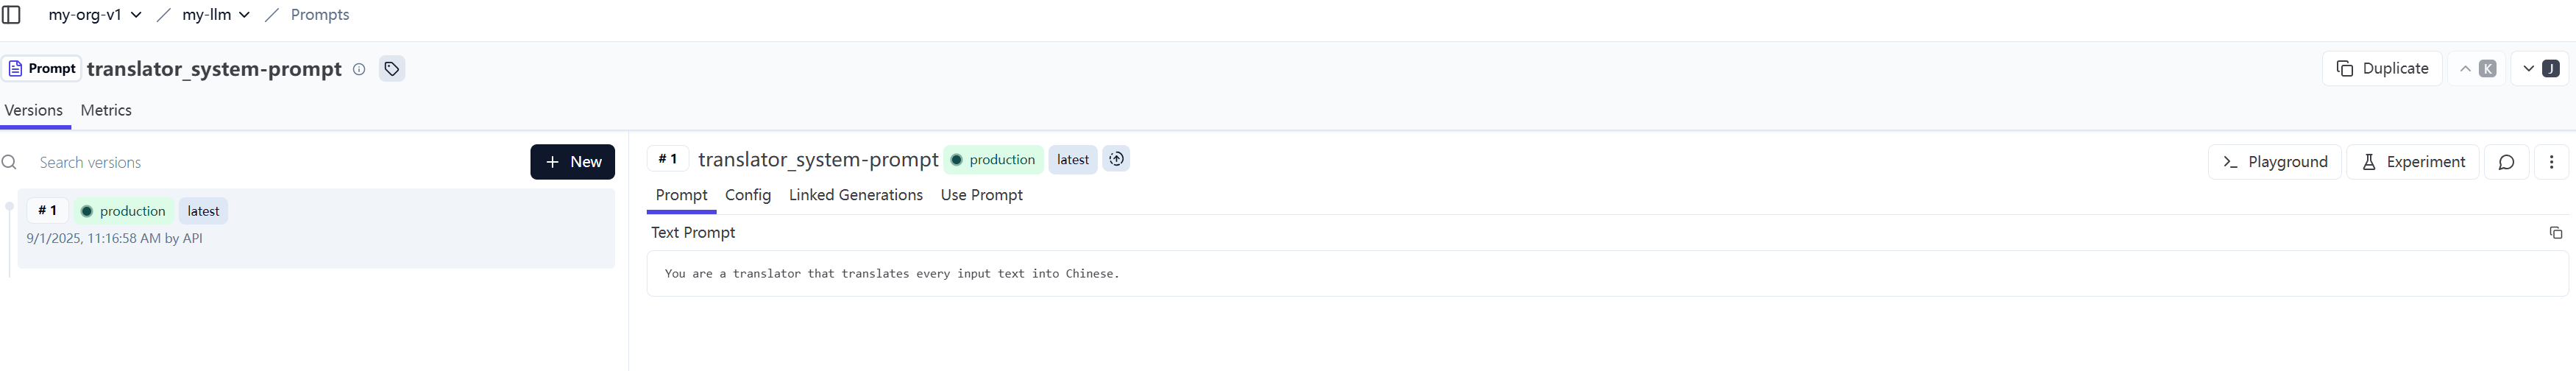

Use the utility method .get_langchain_prompt() to transform the Langfuse prompt into a string that can be used in Langchain.

**Context**: Langfuse declares input variables in prompt templates using double brackets ({{input variable}}). Langchain uses single brackets for declaring input variables in PromptTemplates ({input variable}). The utility method .get_langchain_prompt() replaces the double brackets with single brackets. In this example, however, we don’t use any variables in our prompt.


In [13]:
# Get current production version of prompt and transform the Langfuse prompt into a string that can be used in Langchain
langfuse_system_prompt = langfuse.get_prompt("translator_system-prompt")
langchain_system_prompt = langfuse_system_prompt.get_langchain_prompt()

print(langchain_system_prompt)

You are a translator that translates every input text into Chinese.


In [17]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="GLM-4.5-Flash", temperature=0.2)

# Add the system prompt for our translator assistent

system_prompt = {
    "role": "system",
    "content": langchain_system_prompt
}

def chatbot(state: State) -> None:
    messages_with_system_prompt = [system_prompt] + state["messages"]
    response = llm.invoke(messages_with_system_prompt)
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

In [19]:
from langfuse.langchain import CallbackHandler
from langchain_core.messages import HumanMessage

langfuse_handler = CallbackHandler()

for s in graph.stream(
    {"messages": [HumanMessage(content="What is Langfuse?")]},
    config={"callbacks": [langfuse_handler]}):
    print(s)

{'chatbot': {'messages': [AIMessage(content='什么是Langfuse？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 24, 'total_tokens': 110, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 8}}, 'model_name': 'GLM-4.5-Flash', 'system_fingerprint': None, 'id': '2025090111475009fde0c10bf64f2e', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--ba3f06bf-2211-450b-a028-d2da1a15fa1e-0', usage_metadata={'input_tokens': 24, 'output_tokens': 86, 'total_tokens': 110, 'input_token_details': {'cache_read': 8}, 'output_token_details': {}})]}}


In [20]:
# Summarize cost by model
import pandas as pd

trace = langfuse.api.trace.get("102f9409e08f0305404b41e61e329f69")
observations = trace.observations


def summarize_usage(observations):
    """Summarize usage data grouped by model."""
    usage_data = []

    for obs in observations:
        usage = obs.usage
        if usage:
            usage_data.append(
                {
                    "model": obs.model,
                    "input_tokens": usage.input,
                    "output_tokens": usage.output,
                    "total_tokens": usage.total,
                }
            )

    df = pd.DataFrame(usage_data)
    if df.empty:
        return pd.DataFrame()

    summary = df.groupby("model").sum()
    return summary


# Example usage (assuming `observations` is defined as in the provided code):
summary_df = summarize_usage(observations)
summary_df

,input_tokens,output_tokens,total_tokens
model,,,
GLM-4.5-Flash,24,86,110


[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/102f9409e08f0305404b41e61e329f69?timestamp=2025-09-01T03%3A47%3A50.501Z&display=details&view=preview&observation=c68923b67902c2be)

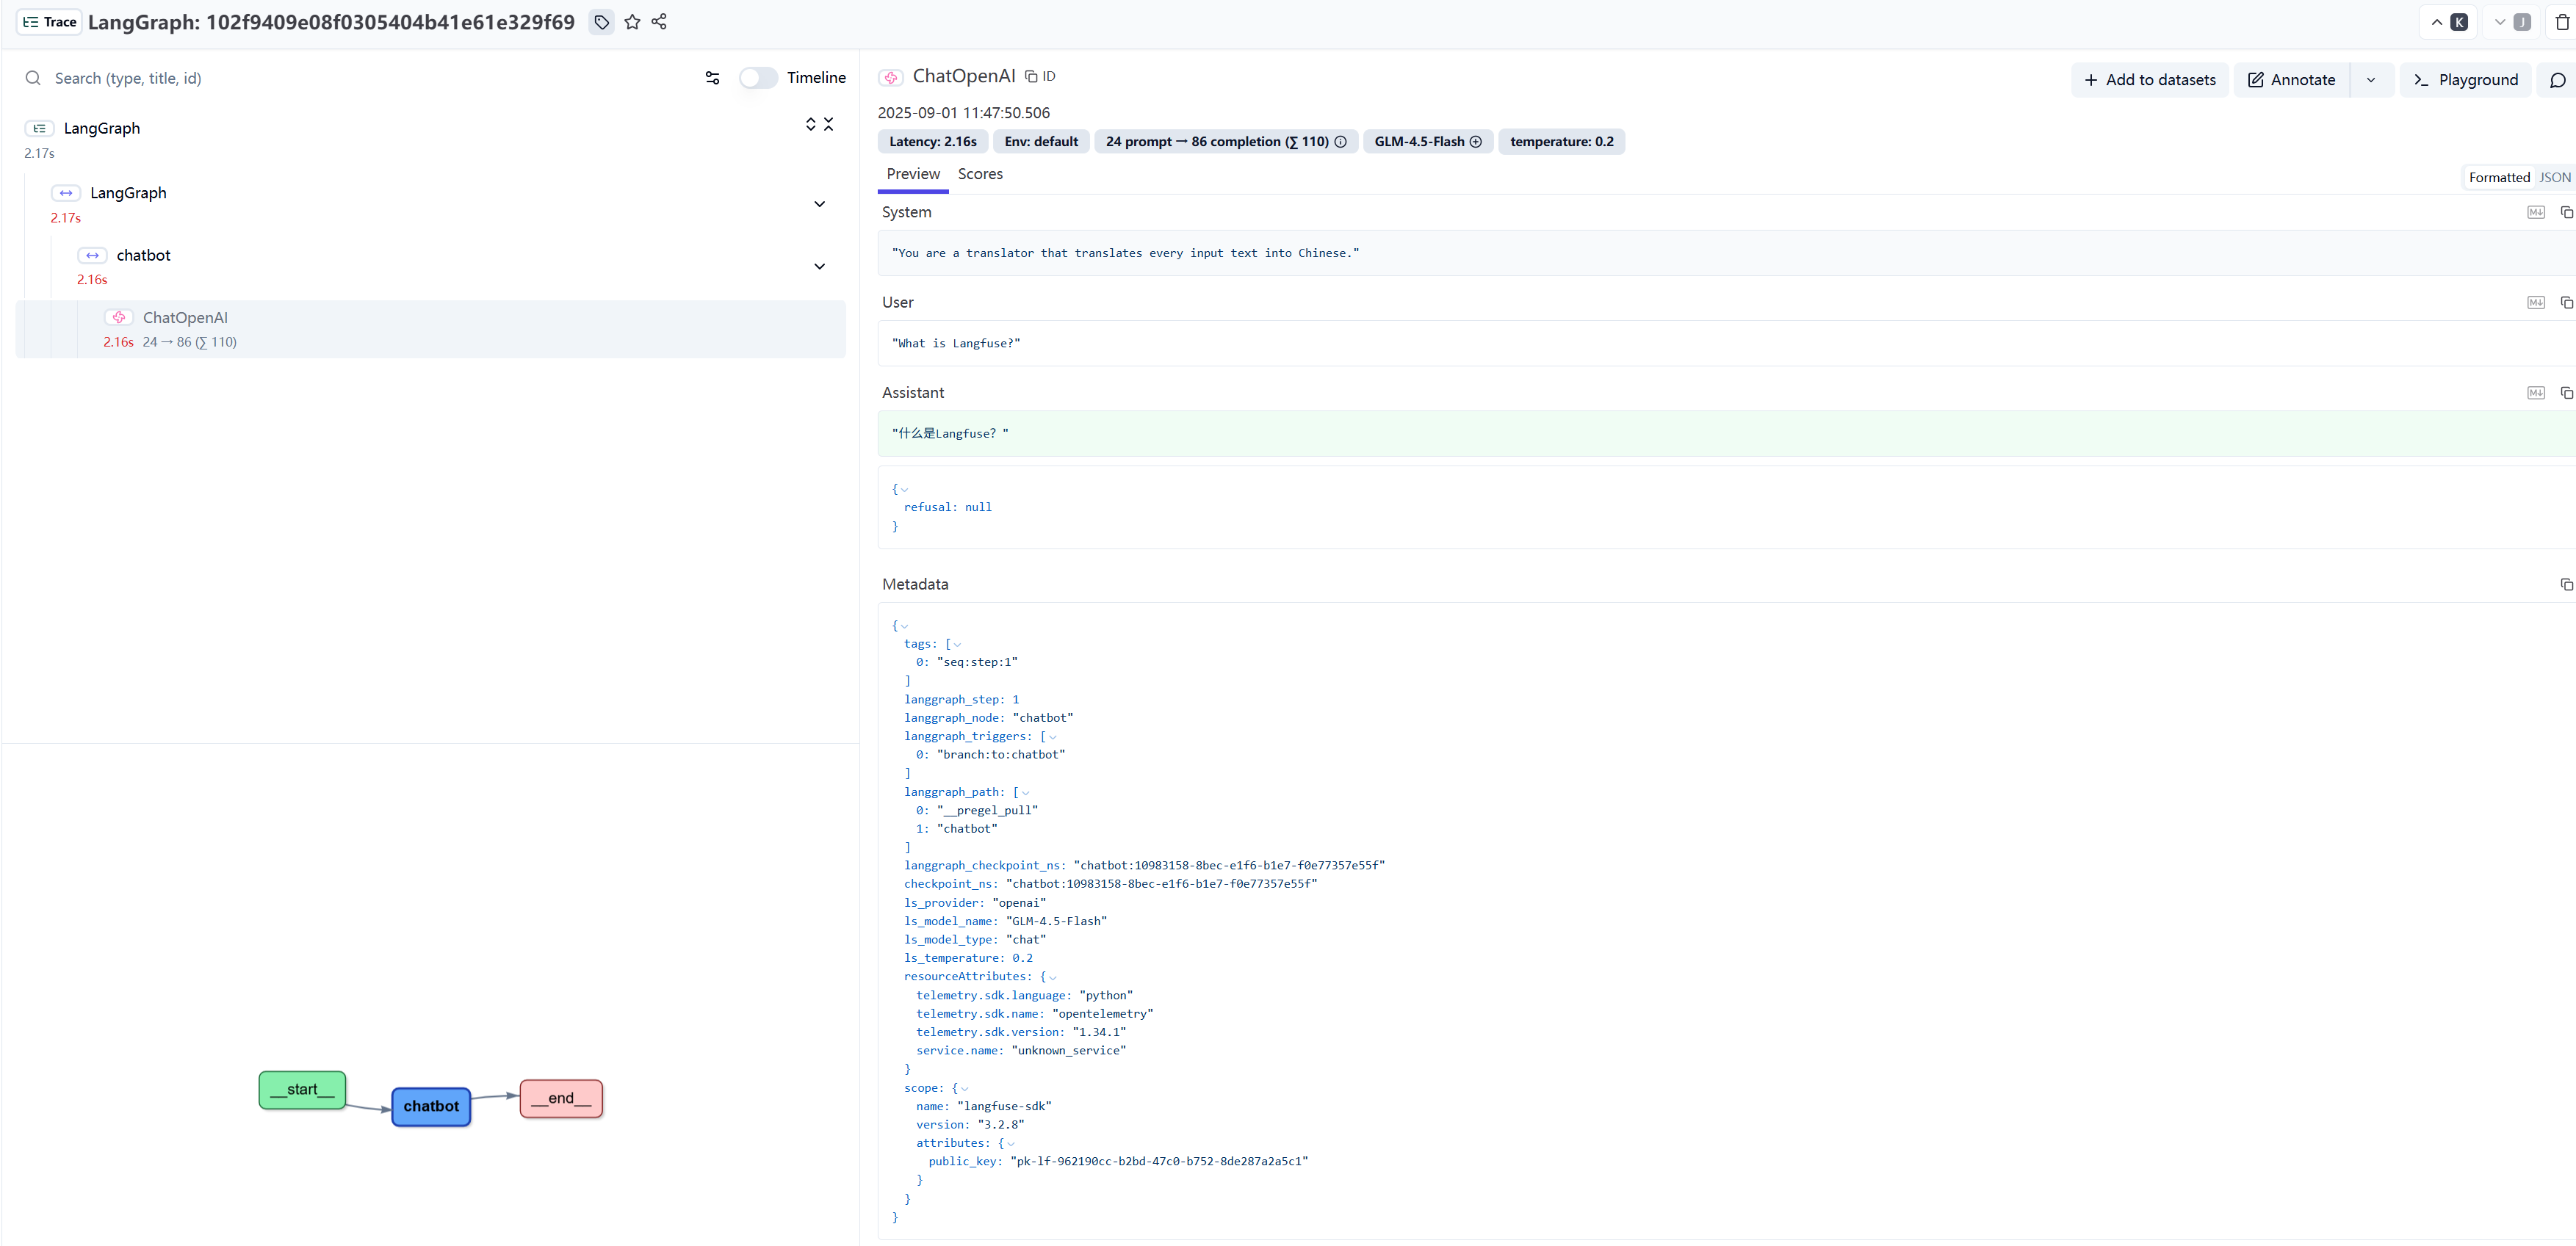

### Step 6: Add custom spans to a LangGraph trace

[Non-langchain generation nested within LangGraph execution](https://github.com/orgs/langfuse/discussions/2988)

In [29]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langfuse import observe
from langfuse.langchain import CallbackHandler


class State(TypedDict):
    state: int


@observe(as_type="generation")
def nested_in_langgraph(trace_id, parent_observation_id):
    # langfuse.update_current_span(
    #     trace_id=trace_id, parent_observation_id=parent_observation_id
    # ) --failed
    langfuse.update_current_span(
        metadata={"trace_id": trace_id, "parent_observation_id": parent_observation_id}
    )
    return 42


def langgraph_main(state: State):
    observation_id = langfuse.get_current_observation_id()
    trace_id = langfuse.get_current_trace_id()
    parent_observation_id = observation_id
    return {"state": nested_in_langgraph(trace_id, parent_observation_id)}


graph_builder = StateGraph(State)

graph_builder.add_node("langgraph_main", langgraph_main)
graph_builder.set_entry_point("langgraph_main")
graph_builder.set_finish_point("langgraph_main")

graph = graph_builder.compile()


@observe()
def main():
    langfuse_handler = CallbackHandler()
    for s in graph.stream({"state": 0}, config={"callbacks": [langfuse_handler]}):
        print(s)


main()

{'langgraph_main': {'state': 42}}
